# 데이터 로드

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 450kB 40.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# 필요 프레임워크 및 라이브러리 준비
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 사전에 정제+정규화된 훈련용 통합 데이터 로드
total_data = pd.read_table('total_data(movie&shopping&game).txt')

In [ ]:
# 통합 데이터 확인
print(len(total_data))

489016
                                            document  label
0                                        이유식 냄비로 좋아요      1
1                                       한글화가 없어서짜징난다      0
2  에휴 존나 뚝 뚝 끊키는대뭘게임을하라고 무슨 핑은좋은대 게임만들어가면 뚝뚝 끊키고 ...      0


In [ ]:
print(total_data[:3])

# 토큰화

In [ ]:
# 불용어 정의 (한국어 조사, 접속사 등) 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 훈련데이터에 형태소 분석기를 사용하여 토큰화를 하면서 불용어 제거
okt = Okt()
X_total = []
for sentence in total_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_total.append(temp_X)

In [ ]:
print(len(X_total))
print(X_total[:3])

489016
[['이유식', '냄비', '로', '좋다'], ['한글화', '없다', '짜다', '징', '난', '다'], ['휴', '존나', '뚝', '뚝', '끊다', '키', '대', '뭘', '게', '이다', '무슨', '핑', '좋다', '게임', '만', '들어가다', '뚝뚝', '끊다', '키', '고', '걸다', '괜찮다', '또', '총', '쏘다', '뚝뚝', '끊다', '키', '고', '해결', '법', '없다', '뭘', '게', '이다']]


In [ ]:
# 토큰화가 오래걸리므로, 반복작업이 용이하도록 파일로 추출해두자
tokened_vocab = X_total
import json
json = json.dumps(tokened_vocab, ensure_ascii=False)
vacab = open("total_data(movie&shopping&game)_tokened_vocab.json", "w", encoding="utf-8")
vacab.write(json)
vacab.close()

# 정수 인코딩

In [ ]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 데이터를 정수로 변환
# 일단 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_total)
 # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.
 # 단어 빈도수가 높은순으로 낮은 정수 인덱스 부여

In [ ]:
# indexed_vocab(vocab) 저장
indexed_vocab = tokenizer.word_index
import json
json = json.dumps(indexed_vocab, ensure_ascii=False)
vacab = open("total_data(movie&shopping&game)_indexed_vocab.json", "w", encoding="utf-8")
vacab.write(json)
vacab.close()

In [ ]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 등장 빈도수가 낮은 데이터를 처리해보자
# 특정 횟수 이하 단어의 비중이 몇인지 체크
threshold = 30
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 85794
등장 빈도가 29번 이하인 희귀 단어의 수: 75702
단어 집합에서 희귀 단어의 비율: 88.2369396461291
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.834712834136931


In [ ]:
# 전체 단어 개수 중 빈도수 12이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 10093


In [ ]:
# 단어집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
#Tokenizer메서드에 숫자를 입력하면 빈도수가 높은 상위 몇개 단어만 사용
tokenizer = Tokenizer(num_words = vocab_size +2, oov_token ='OOV')
# 빈도수 상위 vocab_size단어만 사용, 숫자 0과 OOV를 고려해서 단어 집합의 크기는 +2
tokenizer.fit_on_texts(X_total)
# 여기까지는 보캡길이가 적용안된 것처럼 보임, 실제 적용은 text_to_sequences사용시 적용됨
X_total = tokenizer.texts_to_sequences(X_total)

# vocab_size로 지정한 단어만 보존하고 싶을 때, 굳이 안해도됨
# words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1] # 인덱스가 5 초과인 단어 제거
# for w in words_frequency:
#     del tokenizer.word_index[w] # 해당 단어에 대한 인덱스 정보를 삭제
#     del tokenizer.word_counts[w] # 해당 단어에 대한 카운트 정보를 삭제

# 정수인코딩 결과 확인
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

# 빈도수 상위 vocabsize개수의 단어는 2 ~ vocabsize+1까지의 인덱스를 가졌으며, 그 외 단어 집합에 없는 단어들은 전부 'OOV'의 인덱스인 1로 인코딩
# 케라스 토크나이저는 기본적으로 'OOV'의 인덱스를 1로 지정
# print('단어 OOV의 인덱스 : {}'.format(tokenizer.word_index['OOV']))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
y_total = np.array(total_data['label'])

# 빈 샘플(empty samples)제거

In [ ]:
# 각 샘플의 길이가 0인 샘플들의 인덱스 확인
drop_total = [index for index, sentence in enumerate(X_total) if len(sentence) < 1]
print(drop_total)

[14632, 27170, 28289, 31175, 33805, 37436, 39859, 48040, 99571, 113450, 114946, 126973, 141845, 145702, 168731, 179435, 183863, 187775, 188918, 198198, 215387, 217613, 239681, 246668, 254812, 263465, 284469, 329372, 392273, 403856, 418726, 459309]


In [ ]:
# 빈 샘플들을 제거
X_total = np.delete(X_total, drop_total, axis=0)
y_total = np.delete(y_total, drop_total, axis=0)
print(len(X_total))
print(len(y_total))

488984
488984


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 12.087743157240318


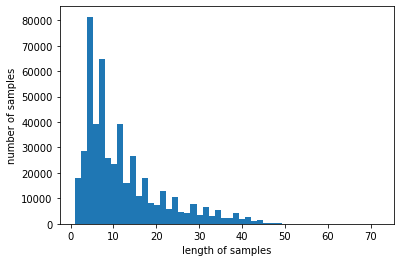

In [ ]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰는 작업
# 전체 데이터에서 가장 길이가 긴 리뷰와, 전체의 길이분포를 알아보자
print('리뷰의 최대 길이 :',max(len(l) for l in X_total))
print('리뷰의 평균 길이 :',sum(map(len, X_total))/len(X_total))
plt.hist([len(s) for s in X_total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 최적의 길이를 찾기 위해, 전체 샘플중 길이가 max_len 이하인 샘플의 비율을 확인하는 함수 생성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
# 35 이하 비율 체크
max_len = 35
below_threshold_len(max_len, X_total)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 96.52626670811316


In [ ]:
# 짧은 데이터는 0을 채우고, 35을 넘는 긴 데이터는 손실됨
X_total = pad_sequences(X_total, maxlen = max_len)

# LSTM/GRU/BiLSTM 모델 훈련

In [ ]:
# 필요한 프레임워크 및 라이브러리 임포트
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 임베딩 벡터의 차원은 100으로, 리뷰분류를 위해 LSTM 사용
# 왜 100인지는 모름
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size+2, 100))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))

In [ ]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size+2, 100))
model_GRU.add(GRU(128))
model_GRU.add(Dense(1, activation='sigmoid'))

In [ ]:
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(vocab_size+2, 100))
model_BiLSTM.add(Bidirectional(LSTM(128)))
model_BiLSTM.add(Dense(1, activation='sigmoid'))

In [ ]:
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# model check point를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_LSTM = ModelCheckpoint('RNN_LSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc_GRU = ModelCheckpoint('RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc_BiLSTM = ModelCheckpoint('RNN_BiLSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# 필요한 매트릭 선언, AUC-ROC, F1-Score, AUC-PR 에 필요한 지표 모두 체크
import tensorflow as tf

ROCauc = tf.keras.metrics.AUC(curve="ROC") # auc_1
PRauc = tf.keras.metrics.AUC(curve="PR") # auc_2
RECALL = tf.keras.metrics.Recall()
PRECISION = tf.keras.metrics.Precision()
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()

In [ ]:
# LSTM모델 훈련
model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_LSTM.fit(X_total, y_total, epochs=15, callbacks=[es, mc_LSTM], batch_size=100, validation_split=0.2)

Epoch 1/15
3912/3912 [==============================] - 76s 16ms/step - loss: 0.3691 - acc: 0.8367 - auc: 0.9158 - auc_1: 0.9134 - recall: 0.8301 - precision: 0.8409 - true_positives: 162190.0000 - true_negatives: 165113.0000 - false_positives: 30686.0000 - false_negatives: 33198.0000 - val_loss: 0.3369 - val_acc: 0.8545 - val_auc: 0.9303 - val_auc_1: 0.9276 - val_recall: 0.8586 - val_precision: 0.8519 - val_true_positives: 42030.0000 - val_true_negatives: 41534.0000 - val_false_positives: 7309.0000 - val_false_negatives: 6924.0000

Epoch 00001: val_acc improved from -inf to 0.85446, saving model to RNN_LSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5
Epoch 2/15
3912/3912 [==============================] - 59s 15ms/step - loss: 0.3250 - acc: 0.8607 - auc: 0.9351 - auc_1: 0.9328 - recall: 0.8566 - precision: 0.8635 - true_positives: 167371.0000 - true_negatives: 169342.0000 - false_positives: 26457.0000 - false_negatives: 28017.0000 - val_loss: 0.3255 - val_acc: 0.8604 - val_auc: 0.9

In [ ]:
# GRU모델 훈련
model_GRU.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_GRU.fit(X_total, y_total, epochs=15, callbacks=[es, mc_GRU], batch_size=100, validation_split=0.2)

Epoch 1/15
3912/3912 [==============================] - 64s 15ms/step - loss: 0.3653 - acc: 0.8392 - auc: 0.9217 - auc_1: 0.9192 - recall: 0.8366 - precision: 0.8495 - true_positives: 204409.0000 - true_negatives: 208420.0000 - false_positives: 36222.0000 - false_negatives: 39933.0000 - val_loss: 0.3371 - val_acc: 0.8545 - val_auc: 0.9311 - val_auc_1: 0.9293 - val_recall: 0.8367 - val_precision: 0.8680 - val_true_positives: 40960.0000 - val_true_negatives: 42612.0000 - val_false_positives: 6231.0000 - val_false_negatives: 7994.0000

Epoch 00001: val_acc improved from -inf to 0.85455, saving model to RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5
Epoch 2/15
3912/3912 [==============================] - 56s 14ms/step - loss: 0.3223 - acc: 0.8620 - auc: 0.9362 - auc_1: 0.9339 - recall: 0.8580 - precision: 0.8646 - true_positives: 167650.0000 - true_negatives: 169538.0000 - false_positives: 26261.0000 - false_negatives: 27738.0000 - val_loss: 0.3248 - val_acc: 0.8608 - val_auc: 0.93

In [ ]:
# BiLSTM모델 훈련
model_BiLSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_BiLSTM.fit(X_total, y_total, epochs=15, callbacks=[es, mc_BiLSTM], batch_size=100, validation_split=0.2)

Epoch 1/15
3912/3912 [==============================] - 89s 21ms/step - loss: 0.3699 - acc: 0.8363 - auc: 0.9189 - auc_1: 0.9164 - recall: 0.8359 - precision: 0.8440 - true_positives: 204252.0000 - true_negatives: 206900.0000 - false_positives: 37742.0000 - false_negatives: 40090.0000 - val_loss: 0.3377 - val_acc: 0.8537 - val_auc: 0.9302 - val_auc_1: 0.9280 - val_recall: 0.8542 - val_precision: 0.8536 - val_true_positives: 41817.0000 - val_true_negatives: 41669.0000 - val_false_positives: 7174.0000 - val_false_negatives: 7137.0000

Epoch 00001: val_acc improved from -inf to 0.85367, saving model to RNN_BiLSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5
Epoch 2/15
3912/3912 [==============================] - 78s 20ms/step - loss: 0.3256 - acc: 0.8606 - auc: 0.9349 - auc_1: 0.9326 - recall: 0.8555 - precision: 0.8641 - true_positives: 167150.0000 - true_negatives: 169514.0000 - false_positives: 26285.0000 - false_negatives: 28238.0000 - val_loss: 0.3270 - val_acc: 0.8605 - val_auc: 0

# LSTM/GRU/BiLSTM 모델 성능평가

In [ ]:
# 평가용 토탈 데이터셋2(화장품+앱)

# 데이터 로드
total_data2 = pd.read_table('total_data(app&cosmetic).txt')

# 토크나이징
X_test_total2 = []
for sentence in total_data2['document']:
    temp_X2 = okt.morphs(sentence, stem=True)
    temp_X2 = [word for word in temp_X2 if not word in stopwords]
    X_test_total2.append(temp_X2)

# 워드 벡터화
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_test_total2)
X_test_total2 = tokenizer.texts_to_sequences(X_test_total2)

# 패딩
X_test_total2 = pad_sequences(X_test_total2, maxlen = max_len)

# 라벨데이터 포함
y_test_total2 = np.array(total_data2['label'])

In [ ]:
# LSTM모델 성능 평가 
loaded_model = load_model('RNN_LSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n LSTM 테스트 결과:",result)

107/107 [==============================] - 2s 7ms/step - loss: 1.1199 - acc: 0.4889 - auc: 0.5240 - auc_1: 0.7206 - recall: 0.4482 - precision: 0.7173 - true_positives: 3342.0000 - true_negatives: 1854.0000 - false_positives: 1317.0000 - false_negatives: 4114.0000

 LSTM 테스트 결과: [1.1198639869689941, 0.4889432489871979, 0.5240488052368164, 0.7206312417984009, 0.4482296109199524, 0.7173213362693787, 3342.0, 1854.0, 1317.0, 4114.0]


In [ ]:
# GRU모델 성능 평가 
loaded_model = load_model('RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n GRU 테스트 결과:",result)

107/107 [==============================] - 2s 6ms/step - loss: 0.9918 - acc: 0.5217 - auc: 0.5261 - auc_1: 0.7215 - recall: 0.5253 - precision: 0.7173 - true_positives: 3917.0000 - true_negatives: 1627.0000 - false_positives: 1544.0000 - false_negatives: 3539.0000

 GRU 테스트 결과: [0.9917809367179871, 0.5216900110244751, 0.5260745286941528, 0.7215461730957031, 0.5253487229347229, 0.7172678709030151, 3917.0, 1627.0, 1544.0, 3539.0]


In [ ]:
# BiLSTM모델 성능 평가 
loaded_model = load_model('RNN_BiLSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n BiLSTM 테스트 결과:",result)

107/107 [==============================] - 2s 8ms/step - loss: 1.1561 - acc: 0.5036 - auc: 0.5204 - auc_1: 0.7186 - recall: 0.4914 - precision: 0.7119 - true_positives: 3664.0000 - true_negatives: 1688.0000 - false_positives: 1483.0000 - false_negatives: 3792.0000

 BiLSTM 테스트 결과: [1.1561497449874878, 0.503622829914093, 0.5203986763954163, 0.718555212020874, 0.4914163053035736, 0.7118709683418274, 3664.0, 1688.0, 1483.0, 3792.0]
